**TEKRAR VE TUTARSIZ OLMASIYLA ALAKALI OPTİMİZE ETMEMİZ GEREKİYOR**
**BU SORUNU DAHA BÜYÜK BİR VERİ SETİ KULLANARAK ÇÖZECEĞİZ**

##1-İmporting libraries

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

##2-Get The Data

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2023-03-10 18:27:23--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.217.214.102, 172.217.214.139, 172.217.214.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ph55g48nird6q9js6febvob9eb2dfbj4/1678472775000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=ff224e79-1684-4c46-8221-76a171c562e9 [following]
--2023-03-10 18:27:27--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ph55g48nird6q9js6febvob9eb2dfbj4/1678472775000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=ff224e79-1684-4c46-8221-76a171c562e9
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to d

* VERİSETİMİZDEN BİR ÖNCEKİ ÇALIŞMADA 100 ŞARKI ÇEKTİĞİMİZ İÇİN MODELDE TEKRAR SORUNU YAŞADIK
* bU SEFER 250 ŞARKI İÇİN EĞİTECEĞİZ
* TÜM VERİ SETİNİ KULLANMIYORUZ ÇÜNKÜ RAM VE ZAMAN TASARRUFU YAPIYORUZ

##3-Preprocessing

In [10]:
def tokenize_corpus(corpus,num_words=-1):
  if num_words > -1:
    tokenizer = Tokenizer(num_words = num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer


def create_lyrics_corpus(dataset,field):
  # Noktalamaları kaldır
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Harfleri küçültelim
  dataset[field] = dataset[field].str.lower()
  #satırlara bölmek için uzun bir dize
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Sondaki boşlukları kaldıralım
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Boş satırları kaldıralım
  corpus = [l for l in corpus if l != '']

  return corpus

##4-Use top Functions

In [15]:


# datasetimizi okuyalım tanımlayalım 
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250] # 250 şarkıda geçen kelimeler ile tokenize sequence and fit işlemlerini yapacaz

# corpus tanımlatalım --> Dataset içindeki field = text leri alacaz
corpus = create_lyrics_corpus(dataset, 'text')

# Tokenize işlemi yapalım 
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

print(" Total Words count is : ",total_words)


 Total Words count is :  2000


<ipython-input-10-ca5898732f99>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


##5-Create Sequences and Labels


In [18]:
sequences =[]

for line in corpus:
  token_list =tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_sequence =token_list[:i+1]
    sequences.append(n_gram_sequence)


# pad sequences for equal input length(Hepsl-i standart olsun diye)
max_sequence_len = max([len(seq) for seq in sequences]) # en uzun cümle sayısını buluyoruz
sequences_padded = np.array(pad_sequences(sequences,maxlen = max_sequence_len,padding = 'pre')) # numpy dizisi yapılmasına dikkat et

# input ve labelleri oluşturalım
input_sequences , labels = sequences_padded[:,:-1] ,sequences_padded[:,-1]

# Etiketleri işlem yapabilmeki için sayılara dönüştürelim(0-1 >>> One Hot Encoding)
one_hot_labels = tf.keras.utils.to_categorical(labels,num_classes = total_words)

## 6 - Train a (Better) Text Generation Model
   * Veri sayımız fazla olduğu için 100 şarkıya göre çok daha iyi bir model olacaktır
   * Veri fazla olduğu için kısa sürmesi için epochs = 100 ayarlayalım
   * Oturum türü GPU yapalım

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words,64,input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words,activation = 'softmax'))

# Model Compile 
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


history = model.fit(input_sequences,one_hot_labels,epochs = 100,verbose = 1)

Epoch 1/100
1480/1480 [==============================] - 30s 13ms/step - loss: 5.9818 - accuracy: 0.0463
Epoch 2/100
1480/1480 [==============================] - 13s 9ms/step - loss: 5.6747 - accuracy: 0.0514
Epoch 3/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.4784 - accuracy: 0.0646
Epoch 4/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.3034 - accuracy: 0.0937
Epoch 5/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.1738 - accuracy: 0.1115
Epoch 6/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.0560 - accuracy: 0.1225
Epoch 7/100
1480/1480 [==============================] - 11s 8ms/step - loss: 4.9412 - accuracy: 0.1326
Epoch 8/100
1480/1480 [==============================] - 11s 8ms/step - loss: 4.8293 - accuracy: 0.1455
Epoch 9/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.7041 - accuracy: 0.1574
Epoch 10/100
1480/1480 [==============================] - 11s 8

##7-View the Training Graph

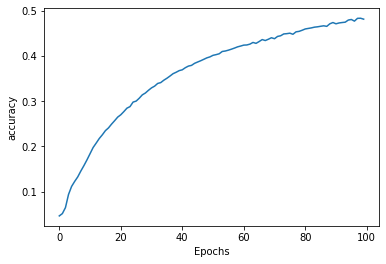

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

##8 Generate better lyrics!
  * Daha az tekrar görerek daha iyi bir şarkı oluşturabiliriz

In [22]:
seed_text = 'im feeling chills'
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list],maxlen = max_sequence_len-1,padding='pre')
  predicted = np.argmax(model.predict(token_list),axis =-1)
  output_word = ""

  for word,index in tokenizer.word_index.items():
    if index==predicted:
      output_word = word
      break
  
  seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 23ms/step
im feeling chills it up me if you wanna be blind but see me feel like me a call but it makes me the jamas town song song my wonderful fight but my hand thing that i meet a while we kissed the screw blow headin tear know kiss me my mind me headin lord lord ah honey lord laugh for me down on it tonight to the bone gets lord harm giant speed rides soldiers soldiers escaping escaping regrets of oasis of true prolonged plague farmer stinky notthekindofgirlyoudmarry goodbye farmer soldiers whispered move on guess on earth rumble and foolish voodoo up


##9-Varying the Possible Outputs
  * OLASI ÇIKTILARI DEĞİŞTİRECEĞİZ
  * BİR ÖNCEKİ YAPTIĞIMIZA BENZER BİR ÇIKTI ALMAMIZIN SEBEBİ EN YAYGIN KELİMELERİ KULLANMASIDAN DOLAYIDIR
  * DAHA FAZLA OLASILIK VERMEMİZİN YOLU model.predict_classes yerine model.predict_proba kullanmaktır
  * Ek olarak np.random.choice ile birleştiririz

In [24]:
seed_text = 'im feeling chills'
next_words = 100


token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list],maxlen = max_sequence_len-1,padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p = predicted_probs)

# 1 hücreyi birden çok kez çalıştırmak çeşitlilik sağlar

print(predicted)

1/1 [==============================] - 0s 39ms/step
224


##10-Use this process for the full output generation
  * Şimdi tam bir çıktı almak için birleştirelim

In [28]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 23ms/step
im feeling chills hard through me back together still shining our dreams pick midnight dreams live and foolish voodoo apple brother edge tuviera huh brain bird mother are uncle awful keep side bags heads most control anywhere think out la fernando breaking cotton giant move single move single move kiss it mother play happen door smile familiar spell ceiling resist most beep knows explode its throwing mustve hearts company and rainy neighbor run need nights try life can be fast and me and win face it up get it up get it together to make them anywhere heads as you scream brokenhearted fuck
